Dataset: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification/code

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os

In [2]:
# The problem with this is that it's assuming all files have the same sample rate, so combine all sample rates to fix this next time
# Load the WAV file

# Read all WAV files in Major and Minor directories
major_files = [os.path.join("dataset/Major", f) for f in os.listdir("dataset/Major") if f.endswith('.wav')]
minor_files = [os.path.join("dataset/Minor", f) for f in os.listdir("dataset/Minor") if f.endswith('.wav')]

# Load all files
major_signals = [np.array(librosa.load(f, sr=None)[0]) for f in major_files]
minor_signals = [np.array(librosa.load(f, sr=None)[0]) for f in minor_files]

major_sample_rates= [np.array(librosa.load(f, sr=None)[1]) for f in major_files]
minor_sample_rates = [np.array(librosa.load(f, sr=None)[1]) for f in minor_files]


In [3]:
major_sample_rates[0]

array(44100)

In [4]:
def extractF0(y):
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=major_sample_rates[0]//2, sr=major_sample_rates[0])
    f0 = f0[~np.isnan(f0)]  # Remove NaN values
    fundamental_freq = np.median(f0)  # Estimate fundamental frequency
    print(f"Estimated Fundamental Frequency (F0): {fundamental_freq:.2f} Hz")
    return fundamental_freq


In [5]:
def extractHarmonics(y, fundamental_freq):
    harmonics = [fundamental_freq * i for i in range(1, 10)]  # First 10 harmonics
    fft_spectrum = np.fft.fft(y)
    frequencies = np.fft.fftfreq(len(fft_spectrum), d=1/major_sample_rates[0])

    # Keep only the positive frequencies
    pos_mask = frequencies > 0
    fft_spectrum = np.abs(fft_spectrum[pos_mask])
    frequencies = frequencies[pos_mask]
    # Find actual harmonic peaks in the spectrum
    peaks, _ = find_peaks(fft_spectrum, height=np.max(fft_spectrum) * 0.1)  # Adjust threshold
    harmonic_freqs = frequencies[peaks]

    # Match found peaks to expected harmonic positions
    extracted_harmonics = [min(harmonic_freqs, key=lambda x: abs(x - h)) for h in harmonics]

    print("Extracted Harmonic Frequencies:", extracted_harmonics)
    return extracted_harmonics


In [ ]:
# Initialize an empty list to store DataFrames
df_list = []

limit = 300   # Limit the number of signals from each side to process
# Iterate over both major and minor signals by using the zip function
for chord, label in zip(major_signals[:limit] + minor_signals[:limit], ["Major"] * limit + ["Minor"] * limit):
    F0 = extractF0(chord)
    extracted_harmonics = extractHarmonics(chord,F0)
    
    # Create a dictionary with the data
    data = {
        'Label': label,
        'F0': [F0]
    }

    # Add harmonics dynamically, first 9 is enough
    for i in range(9):
        data[f'Harmonic_{i+1}'] = [extracted_harmonics[i]]
    
    # Create a DataFrame and append it to the list
    df_harmonics = pd.DataFrame(data)
    df_list.append(df_harmonics)

# Concatenate all DataFrames into a single one
combined_df = pd.concat(df_list, ignore_index=True)


In [9]:
# Saving this as it took ages to extract frequencies
combined_df.to_csv('features.csv', index=False)

In [229]:
# So that won't need to extract features again, use fullset with centroids
combined_df = pd.read_csv('features_with_extras.csv')


In [10]:
#Taking a peak at the data to see what's going on
combined_df.head(10)

,Label,F0,Harmonic_1,Harmonic_2,Harmonic_3,Harmonic_4,Harmonic_5,Harmonic_6,Harmonic_7,Harmonic_8,Harmonic_9
0,Major,65.595405,130.666667,130.666667,196.000000,262.222222,329.333333,392.888889,495.555556,524.888889,589.333333
1,Major,65.595405,165.333333,165.333333,196.444444,261.777778,329.777778,392.444444,496.000000,524.000000,589.777778
2,Major,120.302504,130.909091,234.090909,370.454545,468.181818,555.454545,702.727273,927.272727,937.727273,1113.181818
3,Major,284.481204,278.181818,556.363636,835.000000,1091.363636,1391.818182,1670.454545,1949.090909,1949.090909,1949.090909
4,Major,50.289647,155.909091,155.909091,155.909091,197.727273,278.181818,311.363636,350.454545,392.727273,466.818182
5,Major,281.213658,278.222222,556.444444,834.666667,1112.888889,1391.555556,1670.222222,1949.333333,1949.333333,1949.333333
6,Major,50.000000,156.000000,156.000000,156.000000,196.444444,272.444444,311.111111,350.222222,392.444444,466.666667
7,Major,98.282060,155.454545,195.909091,294.545455,392.272727,466.818182,589.090909,699.090909,784.545455,884.545455
8,Major,50.289647,155.909091,155.909091,155.909091,197.727273,294.090909,294.090909,350.454545,392.727273,466.818182
9,Major,276.382576,278.181818,556.363636,835.000000,1112.727273,1391.818182,1670.454545,1949.090909,1949.090909,1949.090909


In [243]:
# Separate features (X) and labels (y)
X = combined_df.drop(columns=['Label']).values  # Convert to NumPy array
y = combined_df['Label'].map({'Major': 1, 'Minor': 0}).values  # Convert labels to 0 (Minor) and 1 (Major)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalise the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# Add extra dimension to match the output of the model
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader (batching for efficiency)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [248]:
class ChordClassifier(nn.Module):
    def __init__(self, input_size, dropout=0):
        super(ChordClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128) 

        self.fc2 = nn.Linear(128, 64)

        self.fc3 = nn.Linear(64, 32) 

        self.fc4 = nn.Linear(32, 16) 


        self.output = nn.Linear(16, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)

        # Sigmoid activation for binary classification
        x = torch.sigmoid(self.output(x))
        return x

# Initialise model
input_size = X_train.shape[1]  # Number of features
model = ChordClassifier(input_size)


In [251]:
# Binary Cross-Entropy loss for binary classification
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch [10/100], Loss: 0.1595
Epoch [20/100], Loss: 0.2033
Epoch [30/100], Loss: 0.1194
Epoch [40/100], Loss: 0.1382
Epoch [50/100], Loss: 0.0894
Epoch [60/100], Loss: 0.1815
Epoch [70/100], Loss: 0.1072
Epoch [80/100], Loss: 0.0507
Epoch [90/100], Loss: 0.8501
Epoch [100/100], Loss: 0.0536
Training complete!


Neural Network Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        60
           1       0.76      0.73      0.75        60

    accuracy                           0.75       120
   macro avg       0.75      0.75      0.75       120
weighted avg       0.75      0.75      0.75       120



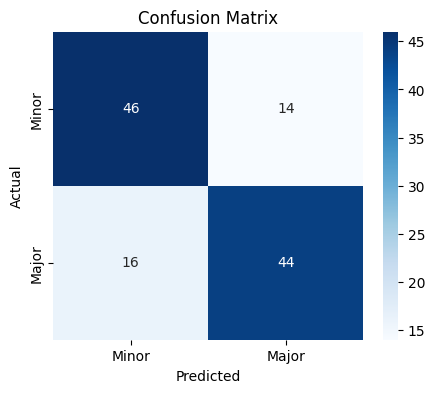

In [254]:
model.eval()
y_pred_list = []

with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        y_pred = model(batch_X)
        y_pred_list.append(y_pred.cpu().numpy())  # Move predictions to CPU and convert to NumPy

# Convert predictions to binary labels (threshold at 0.5)
y_pred_list = np.vstack(y_pred_list)
y_pred_binary = (y_pred_list > 0.5).astype(int).flatten()

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Neural Network Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Minor', 'Major'], yticklabels=['Minor', 'Major'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [253]:
torch.save(model.state_dict(), 'model.pth')

In [187]:
# Decided to add spectral centroid to the features as I was getting low results despite batch normalisation and dropoff

combined_df = pd.read_csv('features.csv')

# Initialize an empty list to store spectral centroid values
spectral_centroids = []
contrasts=[]
rolloffs=[]
for chord, label in zip(major_signals[:limit] + minor_signals[:limit], ["Major"] * limit + ["Minor"] * limit):
    centroid = librosa.feature.spectral_centroid(y=chord)
    contrast = librosa.feature.spectral_contrast(y=chord)
    rolloff = librosa.feature.spectral_rolloff(y=chord)
    spectral_centroids.append(np.mean(centroid))
    contrasts.append(np.mean(contrast))
    rolloffs.append(np.mean(rolloff)) 

# Create a new DataFrame with the spectral centroid values
spectral_centroid_df = pd.DataFrame({'Spectral_Centroid': spectral_centroids})
contrasts_df = pd.DataFrame({'Spectral_Contrast': contrasts})
rolloffs_df = pd.DataFrame({'Spectral_Rolloff': rolloffs})


# Concatenate the new DataFrame with the existing combined_df
combined_df = pd.concat([combined_df, spectral_centroid_df], axis=1)
combined_df = pd.concat([combined_df, contrasts_df], axis=1)
combined_df = pd.concat([combined_df, rolloffs_df], axis=1)

# Saving this as it took ages to extract frequencies
combined_df.to_csv('features_with_extras.csv', index=False)


In [238]:
combined_df.tail()

,Label,F0,Harmonic_1,Harmonic_2,Harmonic_3,Harmonic_4,Harmonic_5,Harmonic_6,Harmonic_7,Harmonic_8,Harmonic_9,Spectral_Centroid,Spectral_Contrast,Spectral_Rolloff
595,Minor,50.000000,146.818182,146.818182,146.818182,220.454545,247.272727,293.636364,350.454545,440.454545,442.272727,307.496813,19.583313,497.870323
596,Minor,73.841615,146.818182,146.818182,220.909091,293.636364,349.545455,442.272727,524.545455,586.818182,663.181818,369.047894,23.163115,590.179765
597,Minor,73.628353,146.818182,146.818182,220.454545,293.636364,350.454545,442.272727,524.090909,524.090909,662.272727,303.999618,19.680502,486.140394
598,Minor,142.240602,146.818182,278.181818,440.454545,556.363636,699.090909,835.000000,1028.636364,1106.818182,1329.090909,375.476145,24.358473,606.839664
599,Minor,72.573061,146.818182,146.818182,220.454545,293.636364,350.454545,440.454545,556.363636,557.272727,661.363636,310.075845,20.207691,490.277035
